# Plots of the prior functions

This notebook provides plots of the prior functions available in `lalapps_pulsar_parameter_estimation_nested`. The plots show samples drawn from the priors using the code and the analyitical form of the functions.

In [2]:
%matplotlib inline

import numpy as np
import subprocess as sp
import os, sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

# matplotlib
import matplotlib as mpl
from matplotlib import pyplot as pl

# scipy
from scipy import stats

from lalapps.pulsarpputils import *
from lalapps.pulsarhtmlutils import exp_str

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [3]:
# the lalapps_pulsar_parameter_estimation_nested code requires are par file to run, so create this

parfile = 'priorfunc.par'
fp = open(parfile, 'w')
par = """PSRJ J0000+0000
RAJ 00:00:00.0
DECJ 00:00:00.0
F0 100.0
PEPOCH 50000
"""
fp.write(par)
fp.close()

# set up location of lalapps_pulsar_parameter_estimation_nested code
virenv = 'lalapps_knope_O2' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')

# number of samples from prior
N = 50000

# code call
codecall = "{} --par-file {} --prior-file {} --sampleprior {} --outfile samples.hdf --Nlive {} --fake-data H1 --Nmcmcinitial 0"

# remove samples file if it already exists 
if os.path.isfile('samples.hdf'):
    os.remove('samples.hdf')

## Uniform prior

A uniform prior between some lower and upper bound. In this case the prior in on the $h_0$ parameter with a range between zero and $5\,\times\,10^{-21}$.

In [3]:
# set the prior file
priorfile = 'priorfunc.prior'
fp = open(priorfile, 'w')
prior = "COSIOTA uniform 0.0 5e-21"
fp.write(prior)
fp.close()

# run code
p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# read in the samples
samples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)

# remove prior file
os.remove(priorfile)

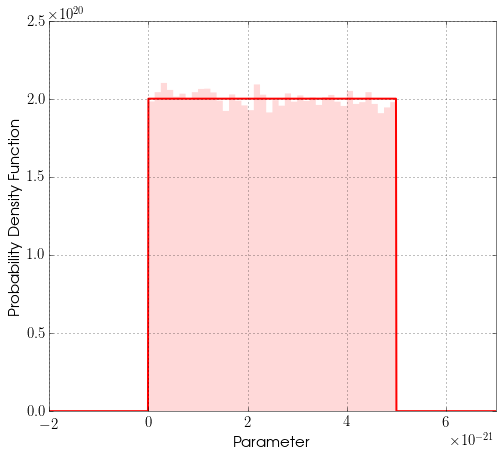

In [4]:
# plot samples
fig = pl.figure(figsize=(8,7))
ax = fig.gca()

ax.hist(samples['cosiota'].samples, bins=40, histtype='stepfilled', alpha=0.15, color='r', normed=True, edgecolor='none')

# over plot analytical distribution
x = np.linspace(-2e-21, 7e-21, 1000)
rv = stats.uniform(loc=0.0, scale=5e-21)
ax.plot(x, rv.pdf(x), color='r', linewidth=2)
ax.set_xlim((x[0], x[-1]))
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Parameter')

if not os.path.isdir('../figures/priors/uniform'):
    os.makedirs('../figures/priors/uniform')

fig.savefig('../figures/priors/uniform/uniform.png', dpi=300)
fig.savefig('../figures/priors/uniform/uniform.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/priors/uniform/uniform.pdf ../figures/priors/uniform/uniform.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/priors/uniform/caption.tex', 'w')
fp.write("""\label{fig:prioruniform}
Samples drawn from the uniform prior distribution.
""")
fp.close()

## Fermi-Dirac prior

A selection of Fermi-Dirac priors with different $\mu$ and $\sigma$ values. 

In [5]:
# set the prior file for a selection of three Fermi-Dirac priors

sigmars = [(1e-21, 3.), (1.5e-21, 9.165), (1.7e-22, 150.)]
samples = []

for sigmar in sigmars:
    priorfile = 'priorfunc.prior'
    fp = open(priorfile, 'w')
    prior = "COSIOTA fermidirac {} {}"
    fp.write(prior.format(sigmar[0], sigmar[1]))
    fp.close()

    # run code
    p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # read in the samples
    thissamples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)
    samples.append(thissamples['cosiota'].samples)
    
    # remove prior file
    os.remove(priorfile)

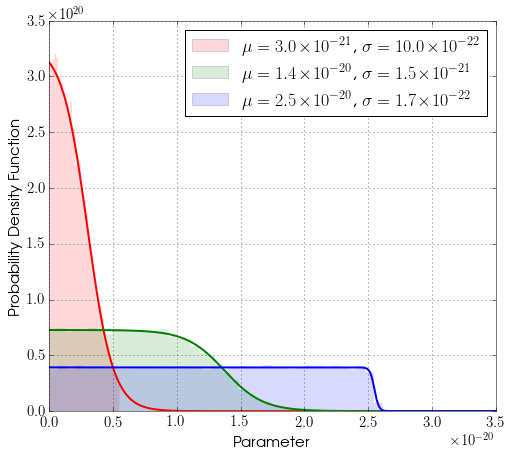

In [6]:
colors = ['r', 'g', 'b']

fig = pl.figure(figsize=(8,7))
ax = fig.gca()

def fermidiracpdf(x, sigma, mu):
    return 1./(sigma*np.log(1.+np.exp(mu/sigma))*(1.+np.exp((x-mu)/sigma)))

x = np.linspace(0, 3.5e-20, 1000)

for i, sigmar in enumerate(sigmars):
    mu = sigmar[0]*sigmar[1]
    ax.hist(samples[i], bins=40, histtype='stepfilled', color=colors[i], normed=True, alpha=0.15,
            edgecolor='none', label=r'$\mu = %s$, $\sigma = %s$' % (exp_str(mu, otype='latex'), exp_str(sigmar[0], otype='latex')))
    ax.plot(x, fermidiracpdf(x, sigmar[0], mu), color=colors[i], linewidth=2)

ax.legend(loc='best')
ax.set_xlim((x[0], x[-1]))
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Parameter')

if not os.path.isdir('../figures/priors/fermidirac'):
    os.makedirs('../figures/priors/fermidirac')

fig.savefig('../figures/priors/fermidirac/fermidirac.png', dpi=300)
fig.savefig('../figures/priors/fermidirac/fermidirac.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/priors/fermidirac/fermidirac.pdf ../figures/priors/fermidirac/fermidirac.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/priors/fermidirac/caption.tex', 'w')
fp.write("""\label{fig:priorfermidirac}
Samples drawn from three Fermi-Dirac prior distribution, with the given $\mu$ and $\sigma$ values.
""")
fp.close()

## Gaussian prior

A Gaussian prior distribution with a mean of 0.2 and a standard deviation of 0.1

In [7]:
# set the prior file
priorfile = 'priorfunc.prior'
fp = open(priorfile, 'w')
prior = "COSIOTA gaussian 0.2 0.1"
fp.write(prior)
fp.close()

# run code
p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# read in the samples
samples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)

# remove prior file
os.remove(priorfile)

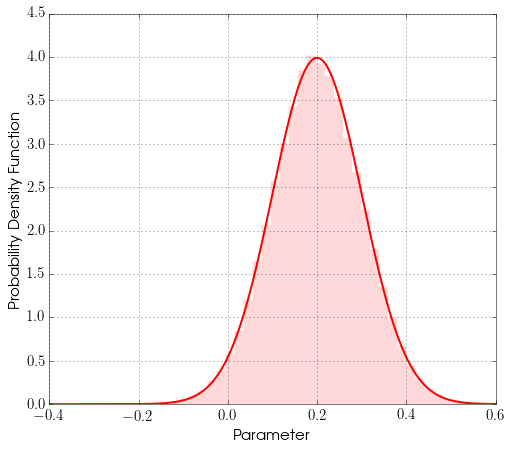

In [8]:
# plot samples
fig = pl.figure(figsize=(8,7))
ax = fig.gca()

ax.hist(samples['cosiota'].samples, bins=40, histtype='stepfilled', alpha=0.15, color='r', normed=True, edgecolor='none')

# over plot analytical distribution
x = np.linspace(-0.4, 0.6, 1000)
rv = stats.norm(loc=0.2, scale=0.1)
ax.plot(x, rv.pdf(x), color='r', linewidth=2)
ax.set_xlim((x[0], x[-1]))
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Parameter')

if not os.path.isdir('../figures/priors/gaussian'):
    os.makedirs('../figures/priors/gaussian')

fig.savefig('../figures/priors/gaussian/gaussian.png', dpi=300)
fig.savefig('../figures/priors/gaussian/gaussian.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/priors/gaussian/gaussian.pdf ../figures/priors/gaussian/gaussian.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/priors/gaussian/caption.tex', 'w')
fp.write("""\label{fig:priorgaussian}
Samples drawn from the Gaussian prior distribution.
""")
fp.close()

## Gaussian mixture model

A couple of Gaussian mixture model prior distributions. One with two modes and another with three modes.

In [6]:
# set the prior file
modes = []
modes.append({'means': [0.1, 0.4], 'sigmas': [0.15, 0.2], 'weights': [2.0, 4.0]})
modes.append({'means': [-0.1, 0.05, 0.2], 'sigmas': [0.02, 0.1, 0.05], 'weights': [8.0, 2.0, 4.5]})

samples = []

for mode in modes:
    priorfile = 'priorfunc.prior'
    fp = open(priorfile, 'w')
    modeformat = "%d " % (len(mode['means']))
    meanstr = '[' + ','.join(['['+str(v)+']' for v in mode['means']]) + ']'
    covstr = '[' + ','.join(['[[' + str(v**2) + ']]' for v in mode['sigmas']]) + ']'
    weightstr = '[' + ','.join([str(v) for v in mode['weights']]) + ']'
    modeformat += "%s %s %s " % (meanstr, covstr, weightstr) 
    prior = "COSIOTA gmm {}"
    fp.write(prior.format(modeformat))
    fp.close()

    # run code
    p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
    out, err = p.communicate()

    # read in the samples
    thissamples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)

    # remove prior file
    os.remove(priorfile)
    samples.append(thissamples['cosiota'].samples)

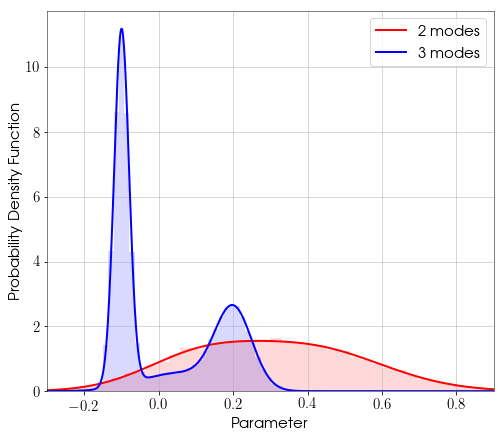

In [7]:
colors = ['r', 'b']

fig = pl.figure(figsize=(8,7))
ax = fig.gca()

def gmmpdf(x, modes):
    gp = np.zeros(len(x))
    for i in range(len(modes['means'])):
        mu = modes['means'][i]
        sigma = modes['sigmas'][i]
        weight = modes['weights'][i]
        rv = stats.norm(loc=mu, scale=sigma) # create mode
        gp += weight*rv.pdf(x) # weight each mode

    # re-normalise
    return gp/np.trapz(gp, x)

x = np.linspace(-0.3, 0.9, 1000)

for i, sample in enumerate(samples):
    ax.hist(sample, bins=50, histtype='stepfilled', color=colors[i], normed=True, alpha=0.15, edgecolor='none')
    ax.plot(x, gmmpdf(x, modes[i]), color=colors[i], linewidth=2, label='%d modes' % len(modes[i]['means']))

ax.legend(loc='best')
ax.set_xlim((x[0], x[-1]))
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Parameter')

if not os.path.isdir('../figures/priors/gmm'):
    os.makedirs('../figures/priors/gmm')

fig.savefig('../figures/priors/gmm/gmm.png', dpi=300)
fig.savefig('../figures/priors/gmm/gmm.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/priors/gmm/gmm.pdf ../figures/priors/gmm/gmm.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/priors/gmm/caption.tex', 'w')
fp.write("""\label{fig:priorgmm}
Samples drawn from two different Gaussian mixture model prior distributions.
""")
fp.close()

## log-Uniform distribution

A prior distribution that is uniform in log-space

In [22]:
# set the prior file
priorfile = 'priorfunc.prior'
fp = open(priorfile, 'w')
prior = "COSIOTA loguniform 1e-3 1.0"
fp.write(prior)
fp.close()

# run code
p = sp.Popen(codecall.format(ppenexec, parfile, priorfile, N, N), stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# read in the samples
samples, evsig, evnoise = pulsar_nest_to_posterior('samples.hdf', nestedsamples=True)

# remove prior file
os.remove(priorfile)

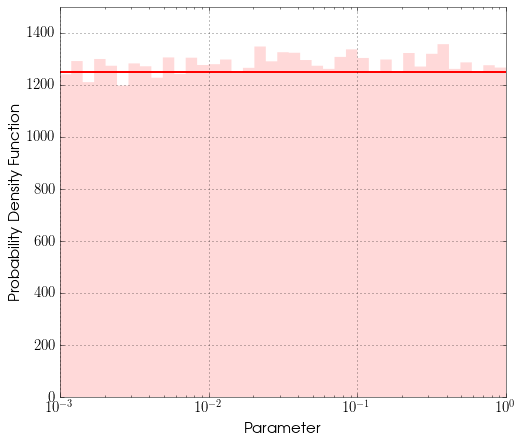

In [45]:
# plot samples
fig = pl.figure(figsize=(8,7))
ax = fig.gca()

bins = np.logspace(-3., 0., 40, base=10.)
ax.hist(samples['cosiota'].samples, bins=bins, histtype='stepfilled', alpha=0.15, color='r', edgecolor='none')

# over plot analytical distribution
x = np.linspace(1e-3, 1, 1000)
rv = stats.uniform(loc=1e-3, scale=(1.-1e-3))
ax.plot(x, rv.pdf(x)*len(samples['cosiota'].samples)/40., color='r', linewidth=2)
ax.set_xscale('log')
ax.set_ylabel('Probability Density Function')
ax.set_xlabel('Parameter')
ax.set_ylim([0., rv.pdf(x)[0]*len(samples['cosiota'].samples)*1.2/40.])

if not os.path.isdir('../figures/priors/loguniform'):
    os.makedirs('../figures/priors/loguniform')

fig.savefig('../figures/priors/loguniform/loguniform.png', dpi=300)
fig.savefig('../figures/priors/loguniform/loguniform.pdf')
# convert to eps
p = sp.Popen('pdftops -eps ../figures/priors/loguniform/loguniform.pdf ../figures/priors/loguniform/loguniform.eps', stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# write out caption
fp = open('../figures/priors/loguniform/caption.tex', 'w')
fp.write("""\label{fig:priorloguniform}
Samples drawn from the log-uniform prior distribution.
""")
fp.close()

In [47]:
# clean up files
os.remove(parfile)
os.remove('samples.hdf')